In [1]:
# max a new set of leiden at high res (e.g. 3) - non batch corrected!
# compute median scrublet score per cluster
# make a new column in obs called 'is_cluster_doublet' and make it boolean
# make a rule so if 'is_cluster_doublet' = true if median score per cluster > threshold (CUT = (MED + (1.4826 * MAD)))
# this will also catch doublets not previously recognised
# counts for both false positives (most powerful) and false negatives

In [2]:
# issac to send script above 

In [3]:
# go back to raw and run leiden at high res with no batch then run above then filter back into 

In [4]:
# leiden in this case segregates data which stands out due to technical effect therefore don't want to correct neighbourhoods

In [5]:
# Run rand and mi embedding between annoatations and embedding both before and after cluster doublet removal and compare - should be both high so don't need to recreate embedding with cluster doublets removed

In [6]:
# Next LR between main rna and citeseq is to just check annotation correlation - not relabel (rna as reference - rand and mi) - script 10

## Doublet Removal

- If apply doublet removal now which was calculated in script 2 this reduces the cell number from 4200 to 3500 which shows for this dataset the 1.4826 cutoff ran in the scrublet script used before is removing too much of the data
- Instead going to re-run scrublet but on high res clusters generated instead and remove cluster doublets to see if that will keep more of the cells
- This will also hopefully account for false positives and negatives in previous run

# Load packages

In [ ]:
import os
import sys
import subprocess
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import scipy.cluster.hierarchy as spc
from pathlib import Path
import scrublet as scr
from scipy.stats import norm
import datetime
import sklearn

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

plt.rcParams['figure.figsize']=(8,8)
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(15, 15))
sc.settings.verbosity = 3

# Load in post-qc raw data

In [35]:
# set place to save outputs
save_path = "nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/scrublet_scores" # Path to save outputs. Note scanpy outputs will be saved in a subfolder at this path location under 'figures'
Object_unique_name = "YS_CiteSeq_RNA_mito_removed_pp_clus_with_LR_meta_adapted_clus_doublet_removed" # Unique name for objects generated from script
scrub_out = '/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/A2_V1_cite_seq_pipeline_181121/scrublet_scores/' # Output for second scrublet runs 

# Load in raw object to run scrublet on again
adata = sc.read("/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Cite_Seq_RNA_simple_raw_27102021.h5ad")

In [36]:
# read precalculated clusters
clus = pd.read_csv('./restricted_leiden_clusters.csv',index_col=0)
adata.obs['restricted_leiden_clusters'] = clus['restricted_leiden_res1_1st_run']

# cumulative distribution function
The cumulative distribution function of a random variable X, evaluated at x, is the probability that X will take a value less than or equal to x. Since the normal distribution is a continuous distribution, the shaded area of the curve represents the probability that X is less or equal than x. Using fill_between(x, y1, y2=0), it will fill up the area between two curves y1 and y2 which has the default value of 0.

![alt text](./cdf_form.png "Title")

# Calculating probability of value < d
$$ MAD = \text{MAD} =  M_i(|x_i-M_j(x_j)|) $$
$$ d = ((1.48 * MAD) + Median) $$
$$ \mathbb{P}(x > q) = 1 - \mathrm{CDF}_d(q) $$

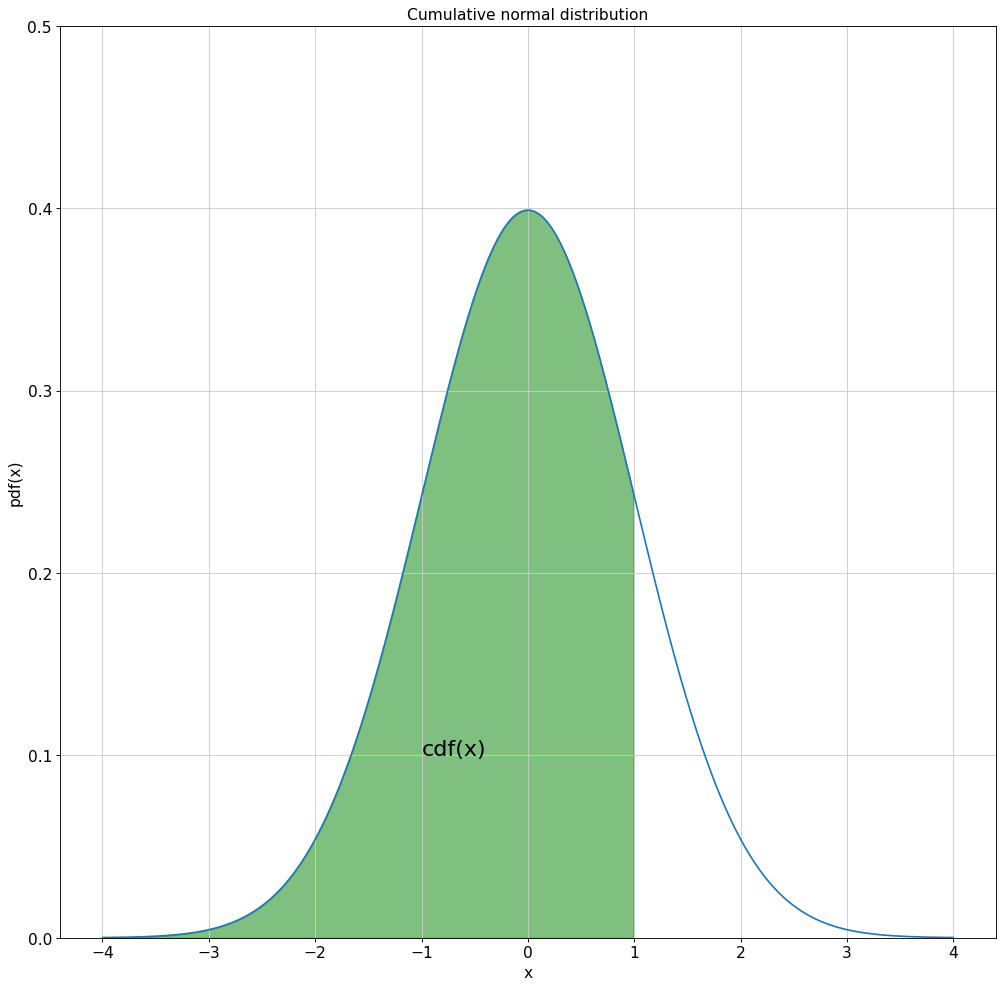

In [3]:
fig, ax = plt.subplots()
# for distribution curve
x= np.arange(-4,4,0.001)
ax.plot(x, norm.pdf(x))
ax.set_title("Cumulative normal distribution")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
# for fill_between
px=np.arange(-4,1,0.01)
ax.set_ylim(0,0.5)
ax.fill_between(px,norm.pdf(px),alpha=0.5, color='g')
# for text
ax.text(-1,0.1,"cdf(x)", fontsize=20)
plt.show()

# Run Scrublet 

In [37]:
#def bh(pvalues):
#    '''
#    Computes the Benjamini-Hochberg FDR correction.
#    
#    Input:
#        * pvals - vector of p-values to correct
#    '''
#    n = int(pvalues.shape[0])
#    new_pvalues = np.empty(n)
#    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
#    values.sort()
#    values.reverse()
#    new_values = []
#    for i, vals in enumerate(values):
#        rank = n - i
#        pvalue, index = vals
#        new_values.append((n/rank) * pvalue)
#    for i in range(0, int(n)-1):
#        if new_values[i] < new_values[i+1]:
#            new_values[i+1] = new_values[i]
#    for i, vals in enumerate(values):
#        pvalue, index = vals
#        new_pvalues[index] = new_values[i]
#    return new_pvalues
######## main
#
##Create output directory
#os.chdir('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/Outputs/scrublet_run2/scrublet_scores')
#
##to set unique date for outputs
#calc_date = datetime.datetime.now()
#date=calc_date.strftime('%Y-%m-%d')
##date=calc_date.strftime('%d-%m-%Y')
#date = date.replace('-', '')
#lanes = 'identifier' # set column to run scrublet on 
#scrublet_concat = pd.DataFrame(columns = ['scrublet_score','scrublet_cluster_score','bh_pval','pval','is_doublet_scrub','scrublet_leiden_R'])
#meta = adata.obs
#sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
#scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval','pval','is_doublet_scrub','scrublet_leiden_R']
####
#for sample in meta[lanes].unique():
#    #import data
#    adata_sample = adata[adata.obs[lanes].isin([sample])]
#    #rename cells to SAMPLE_BARCODE, cleaving the trailing -1
#    #adata_sample.obs_names = [sample+'_'+i.split('-')[0] for i in adata_sample.obs_names]
#    #set up and run Scrublet
#    scrub = scr.Scrublet(adata_sample.X)
#    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
#    adata_sample.obs['scrublet_score'] = doublet_scores
#    adata_sample.obs['is_doublet_scrub'] = predicted_doublets
#    #overcluster prep. run turbo basic scanpy pipeline
#    sc.pp.filter_genes(adata_sample, min_cells=3)
#    sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4)
#    sc.pp.log1p(adata_sample)
#    sc.pp.highly_variable_genes(adata_sample, min_mean=0.0125, max_mean=3, min_disp=0.5)
#    adata_sample = adata_sample[:, adata_sample.var['highly_variable']]
#    sc.pp.scale(adata_sample, max_value=10)
#    sc.tl.pca(adata_sample, svd_solver='arpack')
#    sc.pp.neighbors(adata_sample)
#    #eoverclustering proper - do basic clustering first, then cluster each cluster
#    sc.tl.leiden(adata_sample,key_added= 'scrublet_leiden')
#    key_add  = 'scrublet_leiden_R'
#    for clus in np.unique(adata_sample.obs['scrublet_leiden']):
#        sc.tl.leiden(adata_sample, resolution= 1,key_added=key_add, random_state=26, n_iterations=-1, restrict_to=['scrublet_leiden', [clus]])
#        adata_sample.obs[key_add] = adata_sample.obs[key_add].astype('str')
#        adata_sample.obs[key_add] = adata_sample.obs[key_add] + '_' + sample
#        adata_sample.obs[key_add] = (adata_sample.obs[key_add].replace({',':'_'}, regex=True))
#        adata_sample.obs[key_add] = adata_sample.obs[key_add].astype('category')
#        
#    #compute the cluster scores - the median of Scrublet scores per overclustered cluster
#    #adata_sample.obs['scrublet_leiden_R'] = adata_sample.obs['scrublet_leiden_R'].astype(str)
#    adata_sample.obs['scrublet_cluster_score'] = 0
#    #adata_sample.obs['scrublet_cluster_score'] = adata_sample.obs['scrublet_cluster_score'].astype(float)
#    adata_sample.obs['scrublet_cluster_score'] = adata_sample.obs['scrublet_score'].astype(float)
#    #for clus in np.unique(adata_sample.obs['scrublet_leiden_R']):
#        #adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_cluster_score'] = np.median(adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_score'])
#    #    adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_cluster_score'] = np.mean(adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_score'])
#    #now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
#    #scr_clust_score = adata_sample.obs['scrublet_cluster_score'].unique()
#    #med = np.median(adata_sample.obs['scrublet_cluster_score'])
#    #mask = adata_sample.obs['scrublet_cluster_score']>med
#    #mad = np.median(adata_sample.obs['scrublet_cluster_score'][mask]-med)
#    scr_clust_score = adata_sample.obs['scrublet_cluster_score'].unique()
#    med = np.median(scr_clust_score )
#    mask = scr_clust_score>med
#    mad = np.median(scr_clust_score [mask]-med)
#    
#    #adata_sample.obs['log_scrublet_cluster_score'] = np.log(adata_sample.obs['scrublet_cluster_score'])
#    adata_sample.obs['log_scrublet_cluster_score'] = (adata_sample.obs['scrublet_cluster_score'])
#    
#    MEAN = np.mean(adata_sample.obs['log_scrublet_cluster_score'])
#    SD = np.std(adata_sample.obs['log_scrublet_cluster_score'])
#    #pvals = 1-scipy.stats.norm.cdf(adata_sample.obs['log_scrublet_cluster_score'], loc=med, scale=1.48*mad) #1.4826*mad   NOTE: may need to alter this value
#    pvals = scipy.stats.norm.sf(adata_sample.obs['log_scrublet_cluster_score'], loc=med, scale=1.48*mad) # this is inverse survival function right tailed
#    #Introduce BH correction per cluster instead of by cell
#    adata_sample.obs['bh_pval'] = bh(pvals)
#    adata_sample.obs['pval'] = pvals
#    
#    #create results data frame for single sample and copy stuff over from the adata object
#    scrublet_sample = pd.DataFrame(0, index=adata_sample.obs_names, columns=scorenames)
#    for meta in scorenames:
#        scrublet_sample[meta] = adata_sample.obs[meta]
#    #write out complete sample scores
#    scrublet_sample.to_csv(scrub_out + sample + date +'.csv')
#    scrublet_concat = pd.concat([scrublet_concat,scrublet_sample])
#
##scrublet_concat['bh_pval'] = bh(scrublet_concat['pval'])
#scrublet_concat.to_csv(scrub_out + '/combined_scrublet_scores' + date + '.csv')

# by pre-made clusters

In [38]:
cluster_key = 'restricted_leiden_clusters'

In [39]:
adata.obs['restricted_leiden_clusters']

AAACCCAGTATGGTTC-1-SIGAH5-SIGAH5     1_0
AAACCCAGTTCGGTTA-1-SIGAH5-SIGAH5    17_3
AAACGAAGTTCTTAGG-1-SIGAH5-SIGAH5     1_2
AAACGCTAGGACTGGT-1-SIGAH5-SIGAH5    15_1
AAACGCTCATCACAGT-1-SIGAH5-SIGAH5     1_0
                                    ... 
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5     2_0
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5     5_1
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5     4_3
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5     3_4
TTTGTTGGTGGGTTGA-1-SIGAG5-SIGAG5     2_2
Name: restricted_leiden_clusters, Length: 4061, dtype: object

In [41]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues
####### main

#Create output directory
os.chdir(scrub_out)

#to set unique date for outputs
calc_date = datetime.datetime.now()
date=calc_date.strftime('%Y-%m-%d')
#date=calc_date.strftime('%d-%m-%Y')
date = date.replace('-', '')
lanes = 'identifier' # set column to run scrublet on 
scrublet_concat = pd.DataFrame(columns = ['scrublet_score','scrublet_cluster_score','bh_pval','pval','is_doublet_scrub','scrublet_leiden_R'])
meta = adata.obs
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval','pval','is_doublet_scrub','scrublet_leiden_R']
###
for sample in meta[lanes].unique():
    #import data
    adata_sample = adata[adata.obs[lanes].isin([sample])]
    #rename cells to SAMPLE_BARCODE, cleaving the trailing -1
    #adata_sample.obs_names = [sample+'_'+i.split('-')[0] for i in adata_sample.obs_names]
    #set up and run Scrublet
    scrub = scr.Scrublet(adata_sample.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample.obs['scrublet_score'] = doublet_scores
    adata_sample.obs['is_doublet_scrub'] = predicted_doublets
    #overcluster prep. run turbo basic scanpy pipeline
    sc.pp.filter_genes(adata_sample, min_cells=3)
    sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample)
    sc.pp.highly_variable_genes(adata_sample, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample = adata_sample[:, adata_sample.var['highly_variable']]
    sc.pp.scale(adata_sample, max_value=10)
    sc.tl.pca(adata_sample, svd_solver='arpack')
    sc.pp.neighbors(adata_sample)
    #eoverclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.leiden(adata_sample,key_added= 'scrublet_leiden')
    key_add  = cluster_key
    adata_sample.obs['scrublet_leiden_R'] = adata_sample.obs[key_add][:]
    #for clus in np.unique(adata_sample.obs['scrublet_leiden']):
    #    sc.tl.leiden(adata_sample, resolution= 5,key_added=key_add, random_state=26, n_iterations=-1, restrict_to=['scrublet_leiden', [clus]])
    #    adata_sample.obs[key_add] = adata_sample.obs[key_add].astype('str')
    #    adata_sample.obs[key_add] = adata_sample.obs[key_add] + '_' + sample
    #    adata_sample.obs[key_add] = (adata_sample.obs[key_add].replace({',':'_'}, regex=True))
    #    adata_sample.obs[key_add] = adata_sample.obs[key_add].astype('category')
        
    #compute the cluster scores - the median of Scrublet scores per overclustered cluster
    #adata_sample.obs['scrublet_leiden_R'] = adata_sample.obs['scrublet_leiden_R'].astype(str)
    adata_sample.obs['scrublet_cluster_score'] = 0
    adata_sample.obs['scrublet_cluster_score'] = adata_sample.obs['scrublet_cluster_score'].astype(float)
    #adata_sample.obs['scrublet_cluster_score'] = adata_sample.obs['scrublet_score'].astype(float)
    for clus in np.unique(adata_sample.obs[key_add]):
        #adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_cluster_score'] = np.median(adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_score'])
        adata_sample.obs.loc[adata_sample.obs[key_add]==clus, 'scrublet_cluster_score'] = np.mean(adata_sample.obs.loc[adata_sample.obs[key_add]==clus, 'scrublet_score'])
    #now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    #scr_clust_score = adata_sample.obs['scrublet_cluster_score'].unique()
    #med = np.median(adata_sample.obs['scrublet_cluster_score'])
    #mask = adata_sample.obs['scrublet_cluster_score']>med
    #mad = np.median(adata_sample.obs['scrublet_cluster_score'][mask]-med)
    scr_clust_score = adata_sample.obs['scrublet_cluster_score'].unique()
    med = np.median(scr_clust_score )
    mask = scr_clust_score>med
    mad = np.median(scr_clust_score [mask]-med)
    
    #adata_sample.obs['log_scrublet_cluster_score'] = np.log(adata_sample.obs['scrublet_cluster_score'])
    adata_sample.obs['log_scrublet_cluster_score'] = (adata_sample.obs['scrublet_cluster_score'])
    
    MEAN = np.mean(adata_sample.obs['log_scrublet_cluster_score'])
    SD = np.std(adata_sample.obs['log_scrublet_cluster_score'])
    #pvals = 1-scipy.stats.norm.cdf(adata_sample.obs['log_scrublet_cluster_score'], loc=med, scale=1.48*mad) #1.4826*mad   NOTE: may need to alter this value
    pvals = scipy.stats.norm.sf(adata_sample.obs['log_scrublet_cluster_score'], loc=med, scale=1.48*mad) # this is inverse survival function right tailed
    #Introduce BH correction per cluster instead of by cell
    adata_sample.obs['bh_pval'] = bh(pvals)
    adata_sample.obs['pval'] = pvals
    
    #create results data frame for single sample and copy stuff over from the adata object
    scrublet_sample = pd.DataFrame(0, index=adata_sample.obs_names, columns=scorenames)
    for meta in scorenames:
        scrublet_sample[meta] = adata_sample.obs[meta]
    #write out complete sample scores
    scrublet_sample.to_csv(scrub_out + sample + date +'.csv')
    scrublet_concat = pd.concat([scrublet_concat,scrublet_sample])

#scrublet_concat['bh_pval'] = bh(scrublet_concat['pval'])
scrublet_concat.to_csv(scrub_out + '/combined_scrublet_scores' + date + '.csv')

Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [42]:
len(list(adata_sample.obs['scrublet_leiden_R'].unique()))

123

In [43]:
adata_sample.obs

,identifier,orig.ident,sex,final_anno,final_anno_broad,restricted_leiden_clusters,scrublet_score,is_doublet_scrub,n_counts,scrublet_leiden,scrublet_leiden_R,scrublet_cluster_score,log_scrublet_cluster_score,bh_pval,pval
AAACGAAAGGATTTCC-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Endothelium,Endothelium,16_1,0.041278,False,595.0,14,16_1,0.075475,0.075475,0.975578,0.655834
AAACGAAGTAGTCACT-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Endothelium,Endothelium,21_0,0.024336,False,653.0,14,21_0,0.033260,0.033260,0.975578,0.965805
AAACGCTAGTTGGACG-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Macrophage,Macrophage,10_0,0.063415,False,9972.0,11,10_0,0.121811,0.121811,0.975578,0.123245
AAACGCTGTAGTGCGA-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Endothelium,Endothelium,4_0,0.066890,False,10081.0,1,4_0,0.068067,0.068067,0.975578,0.742326
AAAGAACGTCTTTCAT-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Mast_cell,Mast_cell,12_4,0.083019,False,21394.0,10,12_4,0.073909,0.073909,0.975578,0.675028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Macrophage,Macrophage,2_0,0.092742,False,5618.0,0,2_0,0.088846,0.088846,0.975578,0.480439
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Macrophage,Macrophage,5_1,0.150000,False,25764.0,2,5_1,0.099361,0.099361,0.975578,0.343445
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Endothelium,Endothelium,4_3,0.131980,False,16694.0,9,4_3,0.093859,0.093859,0.975578,0.413779
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Fibroblast,Fibroblast,3_4,0.057011,False,9006.0,12,3_4,0.072773,0.072773,0.975578,0.688674


In [44]:
adata.obs

,identifier,orig.ident,sex,final_anno,final_anno_broad,restricted_leiden_clusters
AAACCCAGTATGGTTC-1-SIGAH5-SIGAH5,SIGAH5,Sample_0,Female,Macrophage,Macrophage,1_0
AAACCCAGTTCGGTTA-1-SIGAH5-SIGAH5,SIGAH5,Sample_0,Female,Lymphoid,Lymphoid,17_3
AAACGAAGTTCTTAGG-1-SIGAH5-SIGAH5,SIGAH5,Sample_0,Female,Macrophage,Macrophage,1_2
AAACGCTAGGACTGGT-1-SIGAH5-SIGAH5,SIGAH5,Sample_0,Female,Erythroid,Erythroid,15_1
AAACGCTCATCACAGT-1-SIGAH5-SIGAH5,SIGAH5,Sample_0,Female,Macrophage,Macrophage,1_0
...,...,...,...,...,...,...
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Macrophage,Macrophage,2_0
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Macrophage,Macrophage,5_1
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Endothelium,Endothelium,4_3
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5,SIGAG5,Sample_0,Female,Fibroblast,Fibroblast,3_4


# Check if pre-computed clustering is optimal K for sample

SIGAH5


ValueError: x and y must have same first dimension, but have shapes (110,) and (114,)

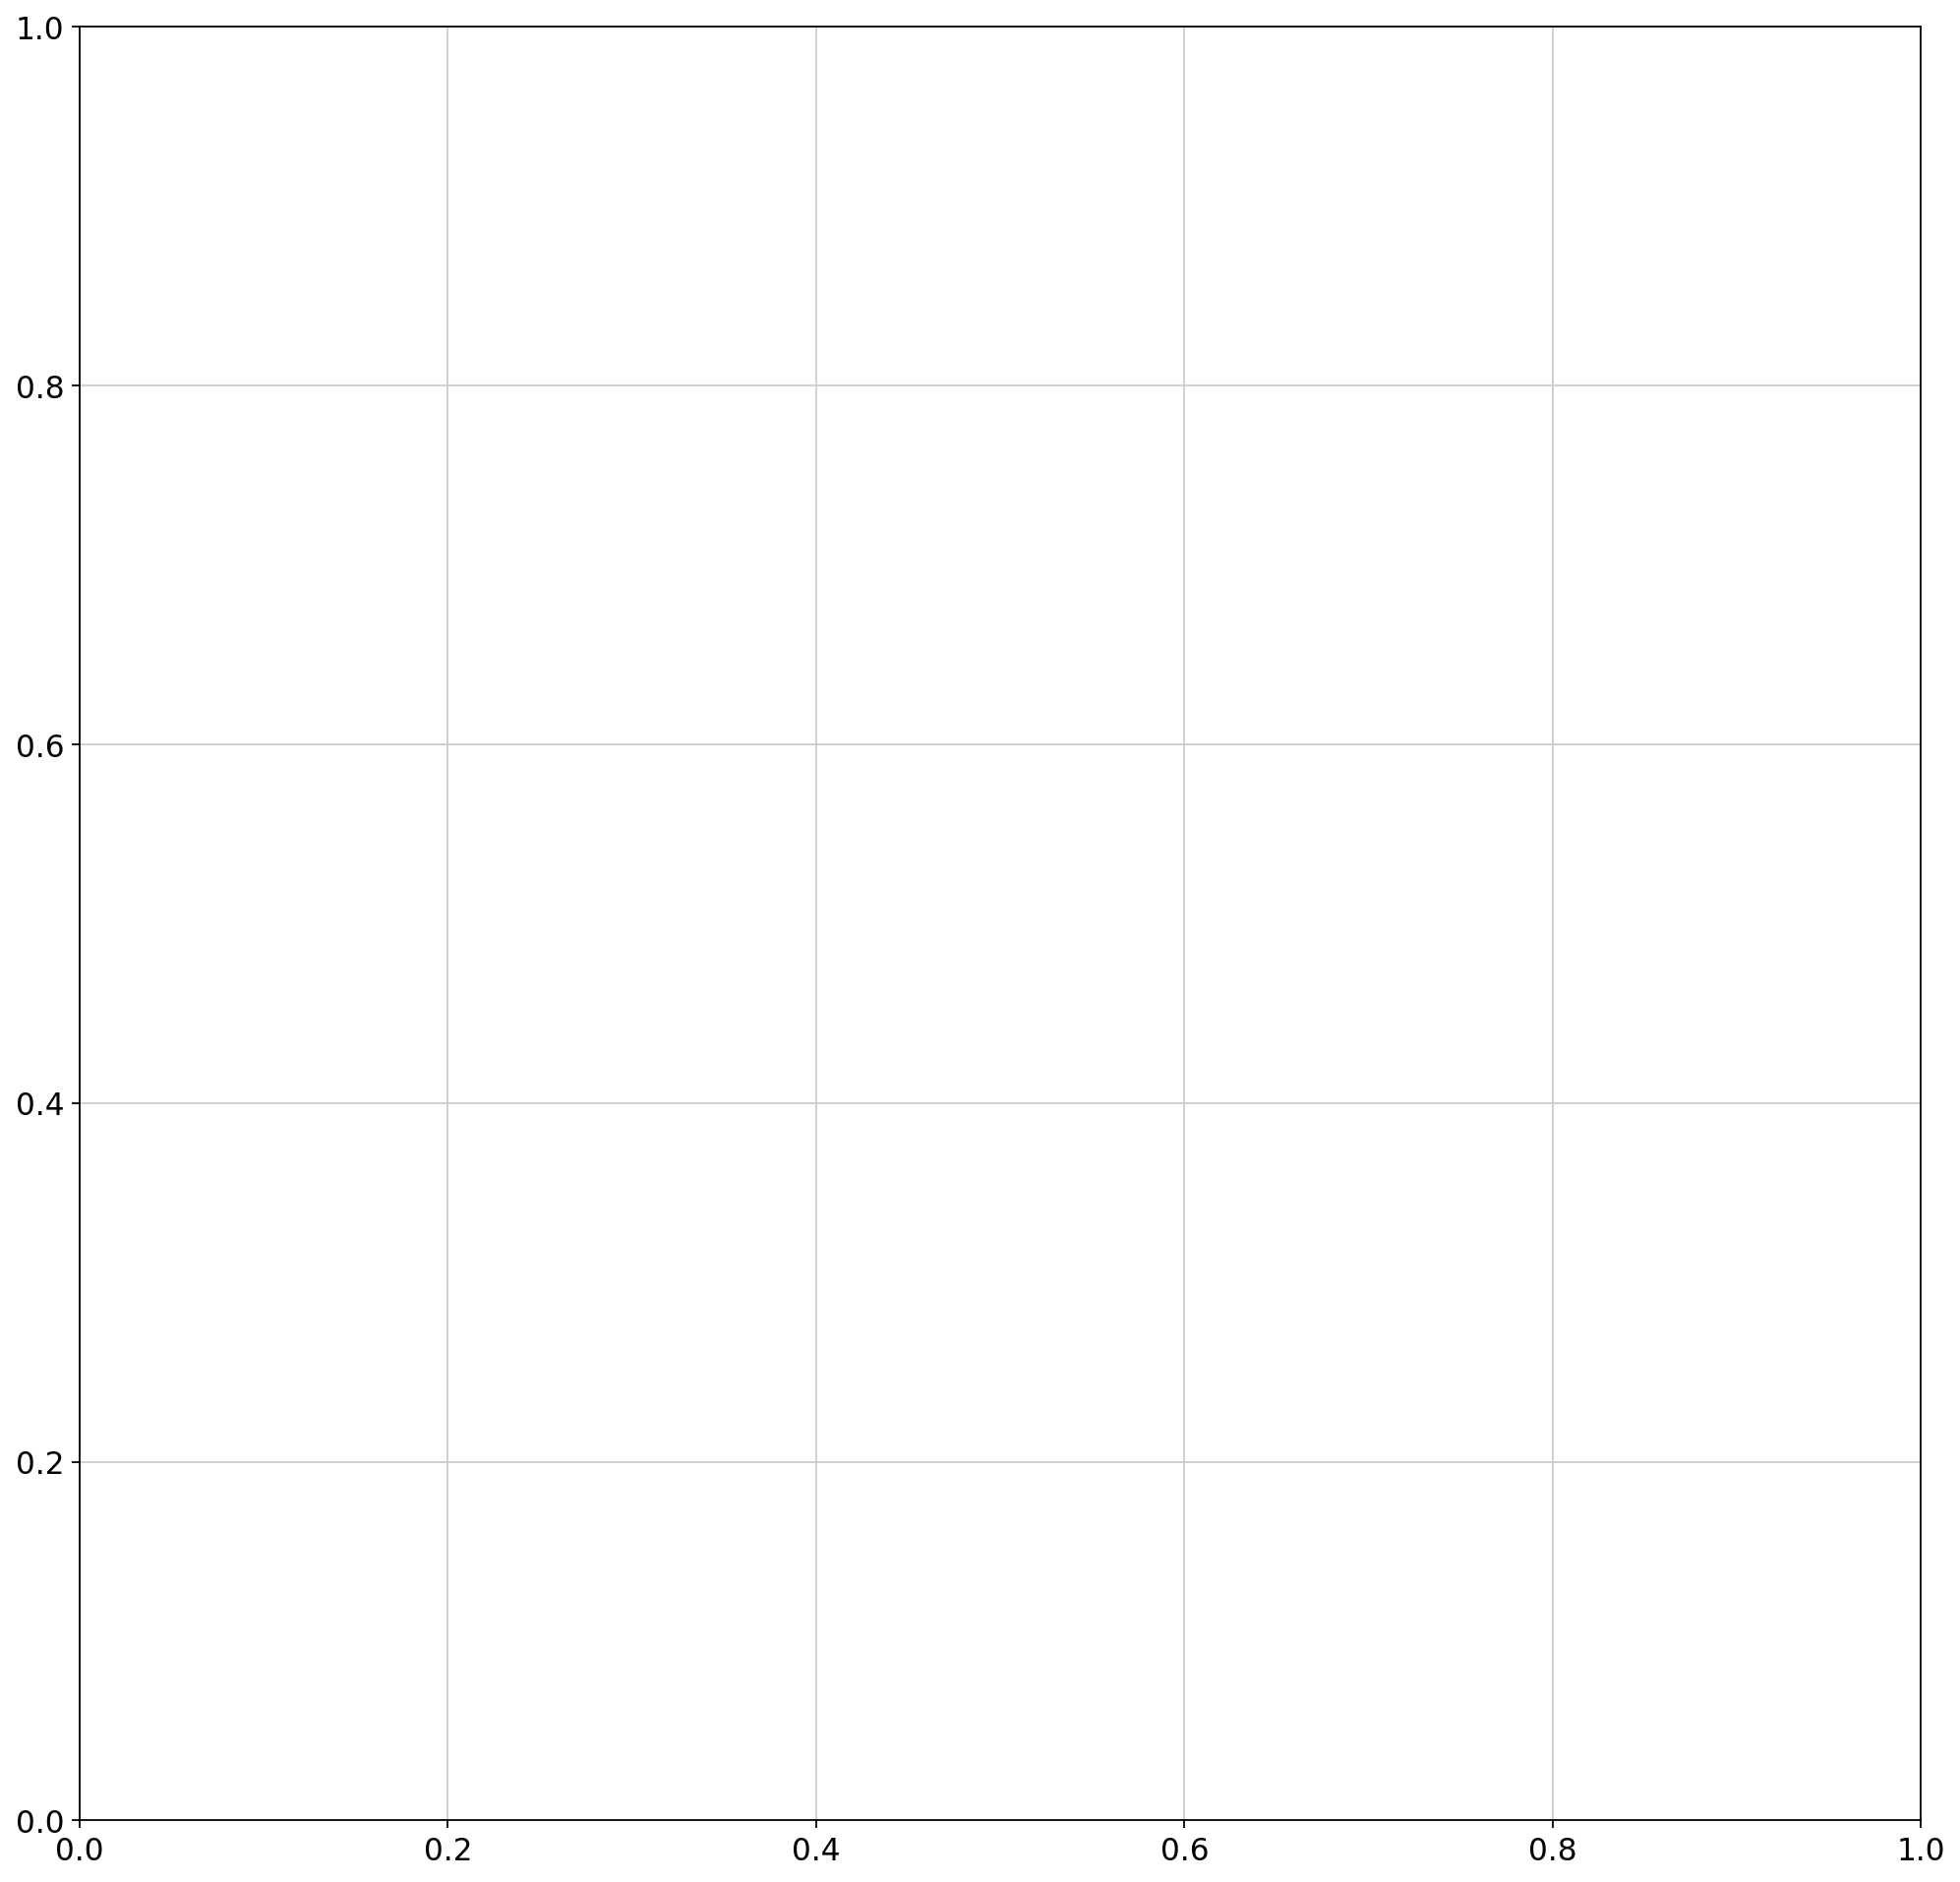

In [46]:
#Create temp_data store
adata_subs = adata
sc_var = 'identifier'
cluster_var = 'restricted_leiden_clusters'

#Interactive loop
for i in list(adata_subs.obs[sc_var].unique()):
    print(i)
    temp = adata_subs[adata_subs.obs[sc_var]==i]
#Calculate PCs
    sc.pp.pca(temp, n_comps=15, use_highly_variable=False, svd_solver='arpack')
    
#Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, 
#and choose the k for which WSS becomes first starts to diminish. 
    max_K = len(temp.obs[cluster_var].unique())
    points = (temp.obsm["X_pca"])[:,0:14]
    
    from sklearn.cluster import KMeans
    def calculate_WSS(points, kmax):
      sse = []
      for k in range(1, kmax+5):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
          curr_center = centroids[pred_clusters[i]]
          curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
        sse.append(curr_sse)
      return sse
    
    WSS = calculate_WSS(points, max_K)
    K = (list(range(1, max_K+1)))
## Sil score
    from sklearn.metrics import silhouette_score
    sil = []
    kmax = max_K
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+2):
        kmeans = KMeans(n_clusters = k).fit((temp.obsm["X_pca"])[:,0:10])
        labels = kmeans.labels_
        sil.append(silhouette_score(points, labels, metric = 'euclidean'))
        
# create figure and axis objects with subplots()
    fig,ax = plt.subplots()
# make a plot
    ax.plot(K, WSS, 'bx-', color="blue")
# set x-axis label
    ax.set_xlabel("K_val",fontsize=14)
# set y-axis label
    ax.set_ylabel("WSS",color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
    ax2=ax.twinx()
    ax2.plot(K, sil, 'bx-',color="red")
    ax2.set_ylabel('sil_score',color="red",fontsize=14)
    plt.title('optimal_K_selection_WSS_vs_sil_score')
#Set X ticks to integer values
    plt.xticks(np.arange(min(K), max(K), 1.0))
    plt.show();
# save the plot as a file
    #fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
    #        format='jpeg',
    #       dpi=100,
    #       bbox_inches='tight')
    
#Output the plot and get the variable "K" of interest
    var1 = "optimum WSS_sil score intersect for k"
    print("Please select {}".format(var1))
    K_var = input('Press ENTER to continue: ')
    print("You've chosen a K value of: "+K_var)
    
#################################/Wait for user input//##########################################
#################################################################################################

In [25]:
adata_sample.obs['log_scrublet_cluster_score'][adata_sample.obs['pval']<0.05].unique()

array([0.15140659, 0.20677966, 0.14736842])

In [26]:
adata_sample.obs['log_scrublet_cluster_score'][adata_sample.obs['pval']<0.05]

AACCTTTCACCCATAA-1-SIGAG5-SIGAG5    0.151407
CAGTTCCGTAGGACCA-1-SIGAG5-SIGAG5    0.151407
TAAGTCGTCACTCACC-1-SIGAG5-SIGAG5    0.151407
TCACTCGAGCCTGTCG-1-SIGAG5-SIGAG5    0.151407
TCAGGGCAGCACCGTC-1-SIGAG5-SIGAG5    0.206780
TCCTGCACAGACAAGC-1-SIGAG5-SIGAG5    0.151407
TGGGAGACACTTCCTG-1-SIGAG5-SIGAG5    0.147368
TTCACCGGTTTCTTAC-1-SIGAG5-SIGAG5    0.151407
Name: log_scrublet_cluster_score, dtype: float64

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

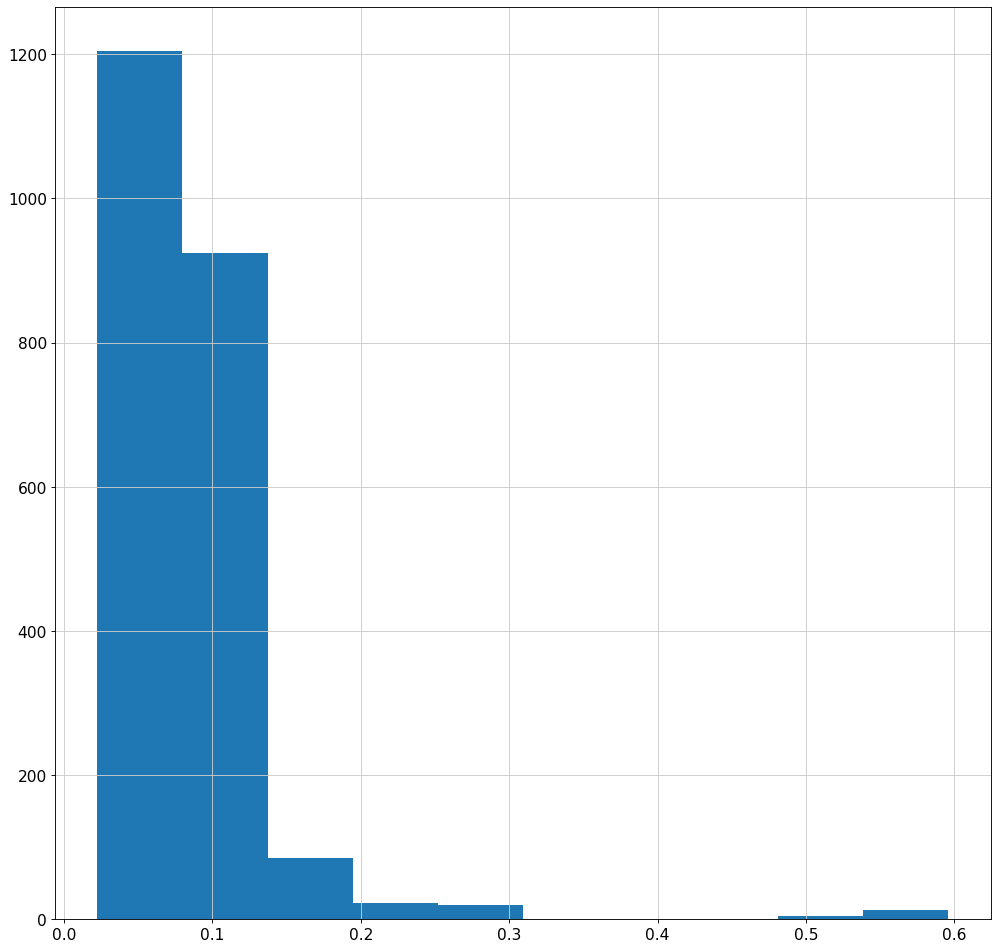

In [11]:
plt.hist(adata_sample.obs['log_scrublet_cluster_score'])
plt.axvline(x=adata_sample.obs['log_scrublet_cluster_score'][adata_sample.obs['pval']<0.05].unique(),color='blue')

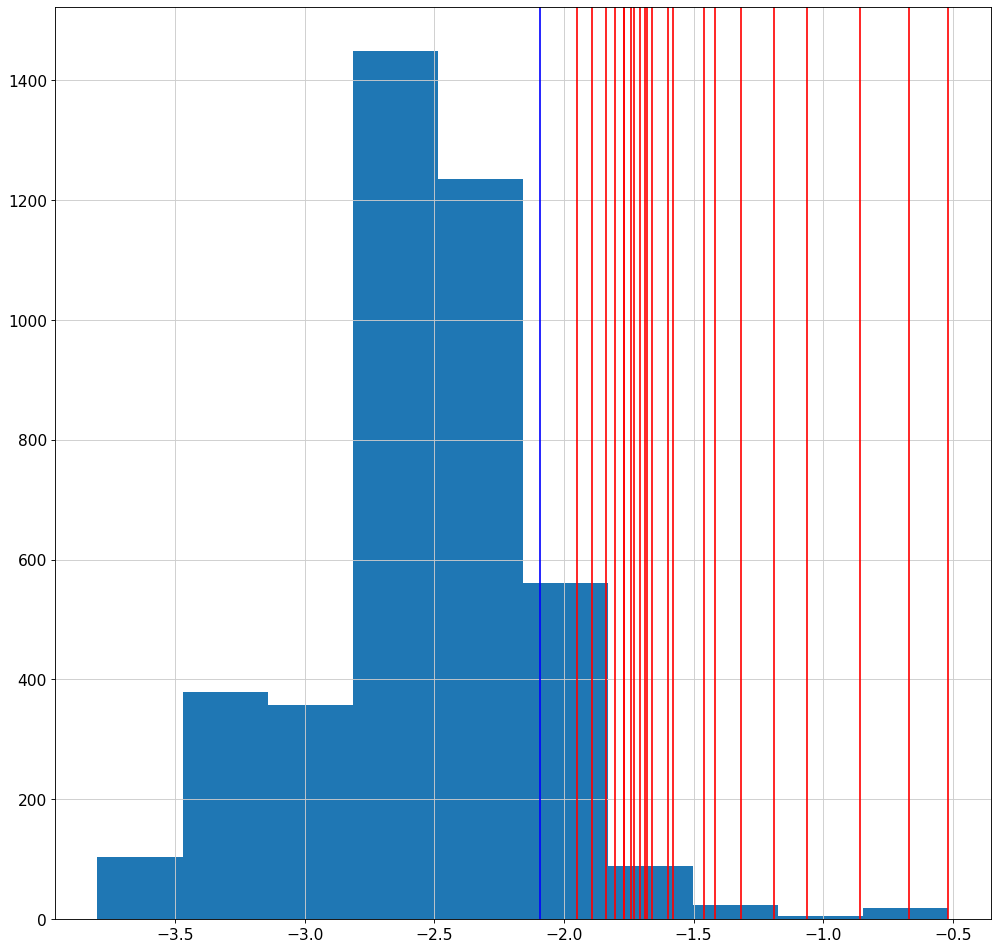

In [12]:
scrublet_concat['log_scrublet_cluster_score'] = np.log(scrublet_concat['scrublet_cluster_score'])

MEAN = np.mean(scrublet_concat['log_scrublet_cluster_score'])
SD = np.std(scrublet_concat['log_scrublet_cluster_score'])
MAD = np.median(np.absolute(scrublet_concat['log_scrublet_cluster_score'] - np.median(scrublet_concat['log_scrublet_cluster_score']))) * 1.48
MED = np.median(scrublet_concat['log_scrublet_cluster_score'])
tresh = MEAN+(1.48*MAD) 
#tresh = MED-(MAD)
plt.hist(scrublet_concat['log_scrublet_cluster_score'])
for i in ((scrublet_concat['log_scrublet_cluster_score'][scrublet_concat['pval'] < 0.05]).unique()):
    plt.axvline(x=i,color='red')
plt.axvline(x=tresh,color='blue')

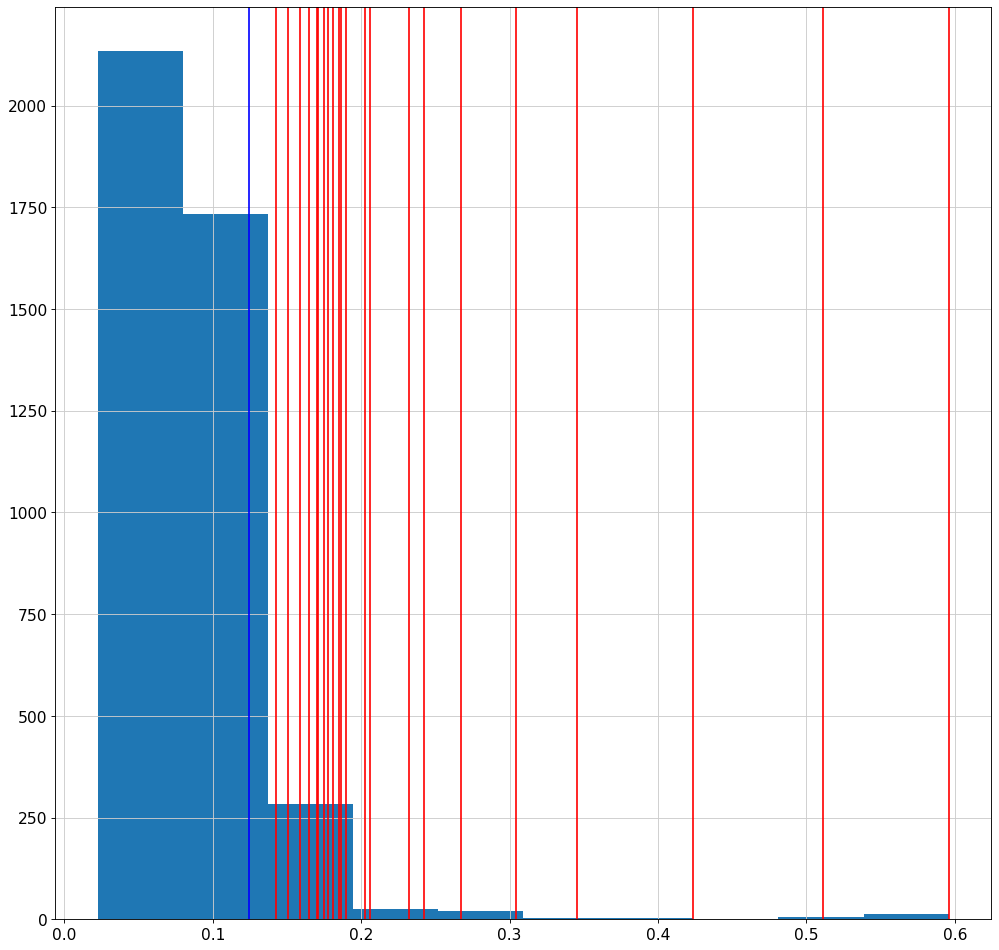

In [13]:
scrublet_concat['log_scrublet_cluster_score'] = np.log(scrublet_concat['scrublet_cluster_score'])

MEAN = np.mean(scrublet_concat['scrublet_cluster_score'])
SD = np.std(scrublet_concat['scrublet_cluster_score'])
MAD = np.median(np.absolute(scrublet_concat['scrublet_cluster_score'] - np.median(scrublet_concat['scrublet_cluster_score']))) * 1.48
MED = np.median(scrublet_concat['scrublet_cluster_score'])
tresh = MEAN+(1.48*MAD) 
#tresh = MED-(MAD)
plt.hist(scrublet_concat['scrublet_cluster_score'])
for i in ((scrublet_concat['scrublet_cluster_score'][scrublet_concat['pval'] < 0.05]).unique()):
    plt.axvline(x=i,color='red')
plt.axvline(x=tresh,color='blue')

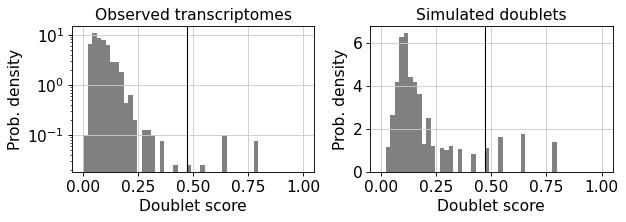

In [76]:
scrub.plot_histogram();

# Read in Scrublet outputs

In [14]:
scrublet_concat = pd.read_csv(scrub_out + 'combined_scrublet_scores' + date + '.csv',index_col=0)

In [15]:
min(scrublet_concat['pval'])

4.518652727050767e-48

In [16]:
min(scrublet_concat['bh_pval'])

7.907642272338841e-46

# Add scrublet output to raw data object 

In [17]:
adata.obs[['scrublet_score','scrublet_cluster_score','scr_bh_pval','scr_pval']] = ''
adata.obs[['scrublet_score','scrublet_cluster_score','scr_bh_pval','scr_pval','scr_doublet_call_default','scrublet_leiden_R']] = scrublet_concat[['scrublet_score','scrublet_cluster_score','bh_pval','pval','is_doublet_scrub','scrublet_leiden_R']]

In [18]:
adata.obs[['scrublet_score','scrublet_cluster_score','scr_bh_pval','scr_pval','scr_doublet_call_default']]

,scrublet_score,scrublet_cluster_score,scr_bh_pval,scr_pval,scr_doublet_call_default
AAACCCAGTATGGTTC-1-SIGAH5-SIGAH5,0.033248,0.040853,0.980645,0.979795,False
AAACCCAGTTCGGTTA-1-SIGAH5-SIGAH5,0.077799,0.088063,0.980645,0.747945,False
AAACGAAGTTCTTAGG-1-SIGAH5-SIGAH5,0.058824,0.069879,0.980645,0.884962,False
AAACGCTAGGACTGGT-1-SIGAH5-SIGAH5,0.033248,0.045845,0.980645,0.971510,False
AAACGCTCATCACAGT-1-SIGAH5-SIGAH5,0.098039,0.040853,0.980645,0.979795,False
...,...,...,...,...,...
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5,0.093023,0.080426,0.952702,0.536254,False
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5,0.122970,0.088186,0.952702,0.448687,False
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5,0.058296,0.076888,0.952702,0.575861,False
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5,0.038509,0.061191,0.952702,0.737705,False


In [19]:
adata.obs['scr_doublet_call_default']

AAACCCAGTATGGTTC-1-SIGAH5-SIGAH5    False
AAACCCAGTTCGGTTA-1-SIGAH5-SIGAH5    False
AAACGAAGTTCTTAGG-1-SIGAH5-SIGAH5    False
AAACGCTAGGACTGGT-1-SIGAH5-SIGAH5    False
AAACGCTCATCACAGT-1-SIGAH5-SIGAH5    False
                                    ...  
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5    False
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5    False
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5    False
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5    False
TTTGTTGGTGGGTTGA-1-SIGAG5-SIGAG5    False
Name: scr_doublet_call_default, Length: 4221, dtype: bool

In [20]:
adata.obs[(adata.obs['scr_pval']<0.05) & (adata.obs['scr_doublet_call_default']==True)]

,identifier,sequencing.type,souporcell_doublet,souporcell_assignment,orig.ident,sex,sex_auto_assign,mad_prd,auto_prd,is_doublet,...,percent.mito,percent.ribo,leiden_res1_1st_run,restricted_leiden_clusters,scrublet_score,scrublet_cluster_score,scr_bh_pval,scr_pval,scr_doublet_call_default,scrublet_leiden_R
TTCAATCTCACCTGTC-1-SIGAH5-SIGAH5,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.025794033,0.12342637,11,11_5,0.647059,0.423529,1.869968e-17,2.882788e-20,True,11_5
AAGACTCAGCACAAAT-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.018177835,0.18810228,4,4_7,0.568000,0.595839,7.907642e-46,4.518653e-48,True,4_7
AATCGACGTAGCTGAG-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.048504777,0.13852637,27,27_0,0.433962,0.304142,1.657177e-08,2.039602e-10,True,27_0
ACTCTCGGTGGTCAAG-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.015090626,0.21139178,27,27_2,0.492958,0.511176,5.228027e-32,4.136461e-34,True,27_2
ACTTTCACAGGACGAT-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.022272887,0.20010522,4,4_7,0.568000,0.595839,7.907642e-46,4.518653e-48,True,4_7
AGCCACGGTGGTCTTA-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.019758,0.17914073,27,27_2,0.568000,0.511176,5.228027e-32,4.136461e-34,True,27_2
AGCTACAAGGGTCACA-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.026828997,0.15464604,12,12_1,0.433962,0.202367,1.423146e-02,3.815908e-04,True,12_1
AGGACGAAGATTTGCC-1-SIGAG5-SIGAG5,SIGAG5,3prime,doublet,1/0,Unassigned,Female,Unassigned,True,False,True,...,0.025790824,0.23048894,27,27_2,0.492958,0.511176,5.228027e-32,4.136461e-34,True,27_2
CAACAACGTCGAACAG-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.039868575,0.21116124,27,27_0,0.386364,0.304142,1.657177e-08,2.039602e-10,True,27_0
CACTTCGGTACTGAGG-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.016595876,0.2157026,4,4_7,0.666667,0.595839,7.907642e-46,4.518653e-48,True,4_7


In [21]:
adata.obs['new_doublets'] = 'False'
adata.obs['new_doublets_bh'] = 'False'
adata.obs.loc[adata.obs['scr_bh_pval']<0.05,'new_doublets_bh'] = "True"
adata.obs.loc[adata.obs['scr_pval']<0.05,'new_doublets'] = "True"
adata.obs[['new_doublets_bh','identifier','new_doublets']].groupby(['identifier','new_doublets_bh','new_doublets']).size()
adata.obs[['new_doublets_bh','identifier','new_doublets']].groupby(['identifier','new_doublets_bh','new_doublets']).size()

identifier  new_doublets_bh  new_doublets
SIGAG5      False            False           2139
                             True              52
            True             False              0
                             True              84
SIGAH5      False            False           1922
                             True              17
            True             False              0
                             True               7
dtype: int64

In [22]:
adata.obs[['identifier','new_doublets']].groupby(['identifier','new_doublets']).size()

identifier  new_doublets
SIGAG5      False           2139
            True             136
SIGAH5      False           1922
            True              24
dtype: int64

In [47]:
adata.obs[['working_broad_cell.labels','new_doublets']].groupby(['working_broad_cell.labels','new_doublets']).size()

working_broad_cell.labels             new_doublets
DCYS_main_object_training             False             42
                                      True              21
EndodermYS_main_object_training       False            149
                                      True               2
EndotheliumYS_main_object_training    False            478
                                      True              27
ErythroidYS_main_object_training      False            431
                                      True               9
FibroblastYS_main_object_training     False            948
                                      True               6
LymphoidYS_main_object_training       False            150
                                      True               0
MKYS_main_object_training             False             97
                                      True               2
MacrophageYS_main_object_training     False           1319
                                      True              51
Mast_

In [42]:
adata.obs['new_doublets'].value_counts()

False    4061
True      160
Name: new_doublets, dtype: int64

In [23]:
len(list(adata.obs.index[adata.obs['new_doublets_bh']=='True']))

91

In [24]:
len(list(adata.obs.index[adata.obs['new_doublets']=='True']))

160

In [46]:
adata.obs.columns

Index(['identifier', 'sequencing.type', 'souporcell_doublet',
       'souporcell_assignment', 'orig.ident', 'sex', 'sex_auto_assign',
       'mad_prd', 'auto_prd', 'is_doublet', 'nUMI', 'nGene', 'nCounts',
       'percent.mito', 'percent.ribo', 'n_counts', 'leiden_res1_1st_run',
       'LR_indiv_pred', 'leiden_res1_1st_run_clus_redistribution',
       'leiden_LR_clus_prediction_res5', 'working_broad_cell.labels',
       'leiden_cluster10_restricted', 'scrublet_score',
       'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval', 'new_doublets',
       'new_doublets_bh', 'scr_doublet_call_default', 'scrublet_leiden_R'],
      dtype='object')

In [26]:
adata.obs['scrublet_leiden_R']

AAACCCAGTATGGTTC-1-SIGAH5-SIGAH5     1_0
AAACCCAGTTCGGTTA-1-SIGAH5-SIGAH5    17_3
AAACGAAGTTCTTAGG-1-SIGAH5-SIGAH5     1_2
AAACGCTAGGACTGGT-1-SIGAH5-SIGAH5    15_1
AAACGCTCATCACAGT-1-SIGAH5-SIGAH5     1_0
                                    ... 
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5     2_0
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5     5_1
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5     4_3
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5     3_4
TTTGTTGGTGGGTTGA-1-SIGAG5-SIGAG5     2_2
Name: scrublet_leiden_R, Length: 4221, dtype: object

# Add in this metadata into annotated object

In [27]:
# Load in processed object
processed_adata = sc.read('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/Outputs/YS_CiteSeq_RNA_mito_removed_pp_clus_with_LR_meta_adapted20210928.h5ad')

In [28]:
processed_adata.obs['scrublet_score'] = adata.obs['scrublet_score']
processed_adata.obs['scrublet_cluster_score'] = adata.obs['scrublet_cluster_score']
processed_adata.obs['scr_bh_pval'] = adata.obs['scr_bh_pval']
processed_adata.obs['scr_pval'] = adata.obs['scr_pval']
processed_adata.obs['new_doublets'] = adata.obs['new_doublets']
processed_adata.obs['new_doublets_bh'] = adata.obs['new_doublets_bh']
processed_adata.obs['scr_doublet_call_default'] = adata.obs['scr_doublet_call_default']
processed_adata.obs['scrublet_leiden_R'] = adata.obs['scrublet_leiden_R']

In [29]:
adata = processed_adata[:]

In [30]:
adata.obs['scr_doublet_call_default'] = adata.obs['scr_doublet_call_default'].astype(str)

Trying to set attribute `.obs` of view, copying.


In [31]:
adata.obsp.keys()

KeysView(PairwiseArrays with keys: 1st_run_neighbors_connectivities, 1st_run_neighbors_distances, 1st_run_neighbors_harmony_connectivities, 1st_run_neighbors_harmony_distances)

In [32]:
#Option 2 restrict clustering of all categories

#res = 0.5
#key_add = 'restricted_leiden_res1_1st_run'

#adata.obs[key_add] = adata.obs['leiden_res1_1st_run']

#for i in adata.obs[key_add].unique() :
#    sc.tl.leiden(adata, resolution= res,key_added= key_add, random_state=26, n_iterations=-1, restrict_to=[key_add, [i]],neighbors_key = '1st_run_neighbors_harmony')
#    #Replace all ',' with '_'
#adata.obs[key_add] = adata.obs[key_add].astype('str')
#adata.obs[key_add] = (adata.obs[key_add].replace({',':'_'}, regex=True))
#adata.obs[key_add] = adata.obs[key_add].astype('category')

... storing 'new_doublets' as categorical
... storing 'new_doublets_bh' as categorical
... storing 'scr_doublet_call_default' as categorical
... storing 'scrublet_leiden_R' as categorical


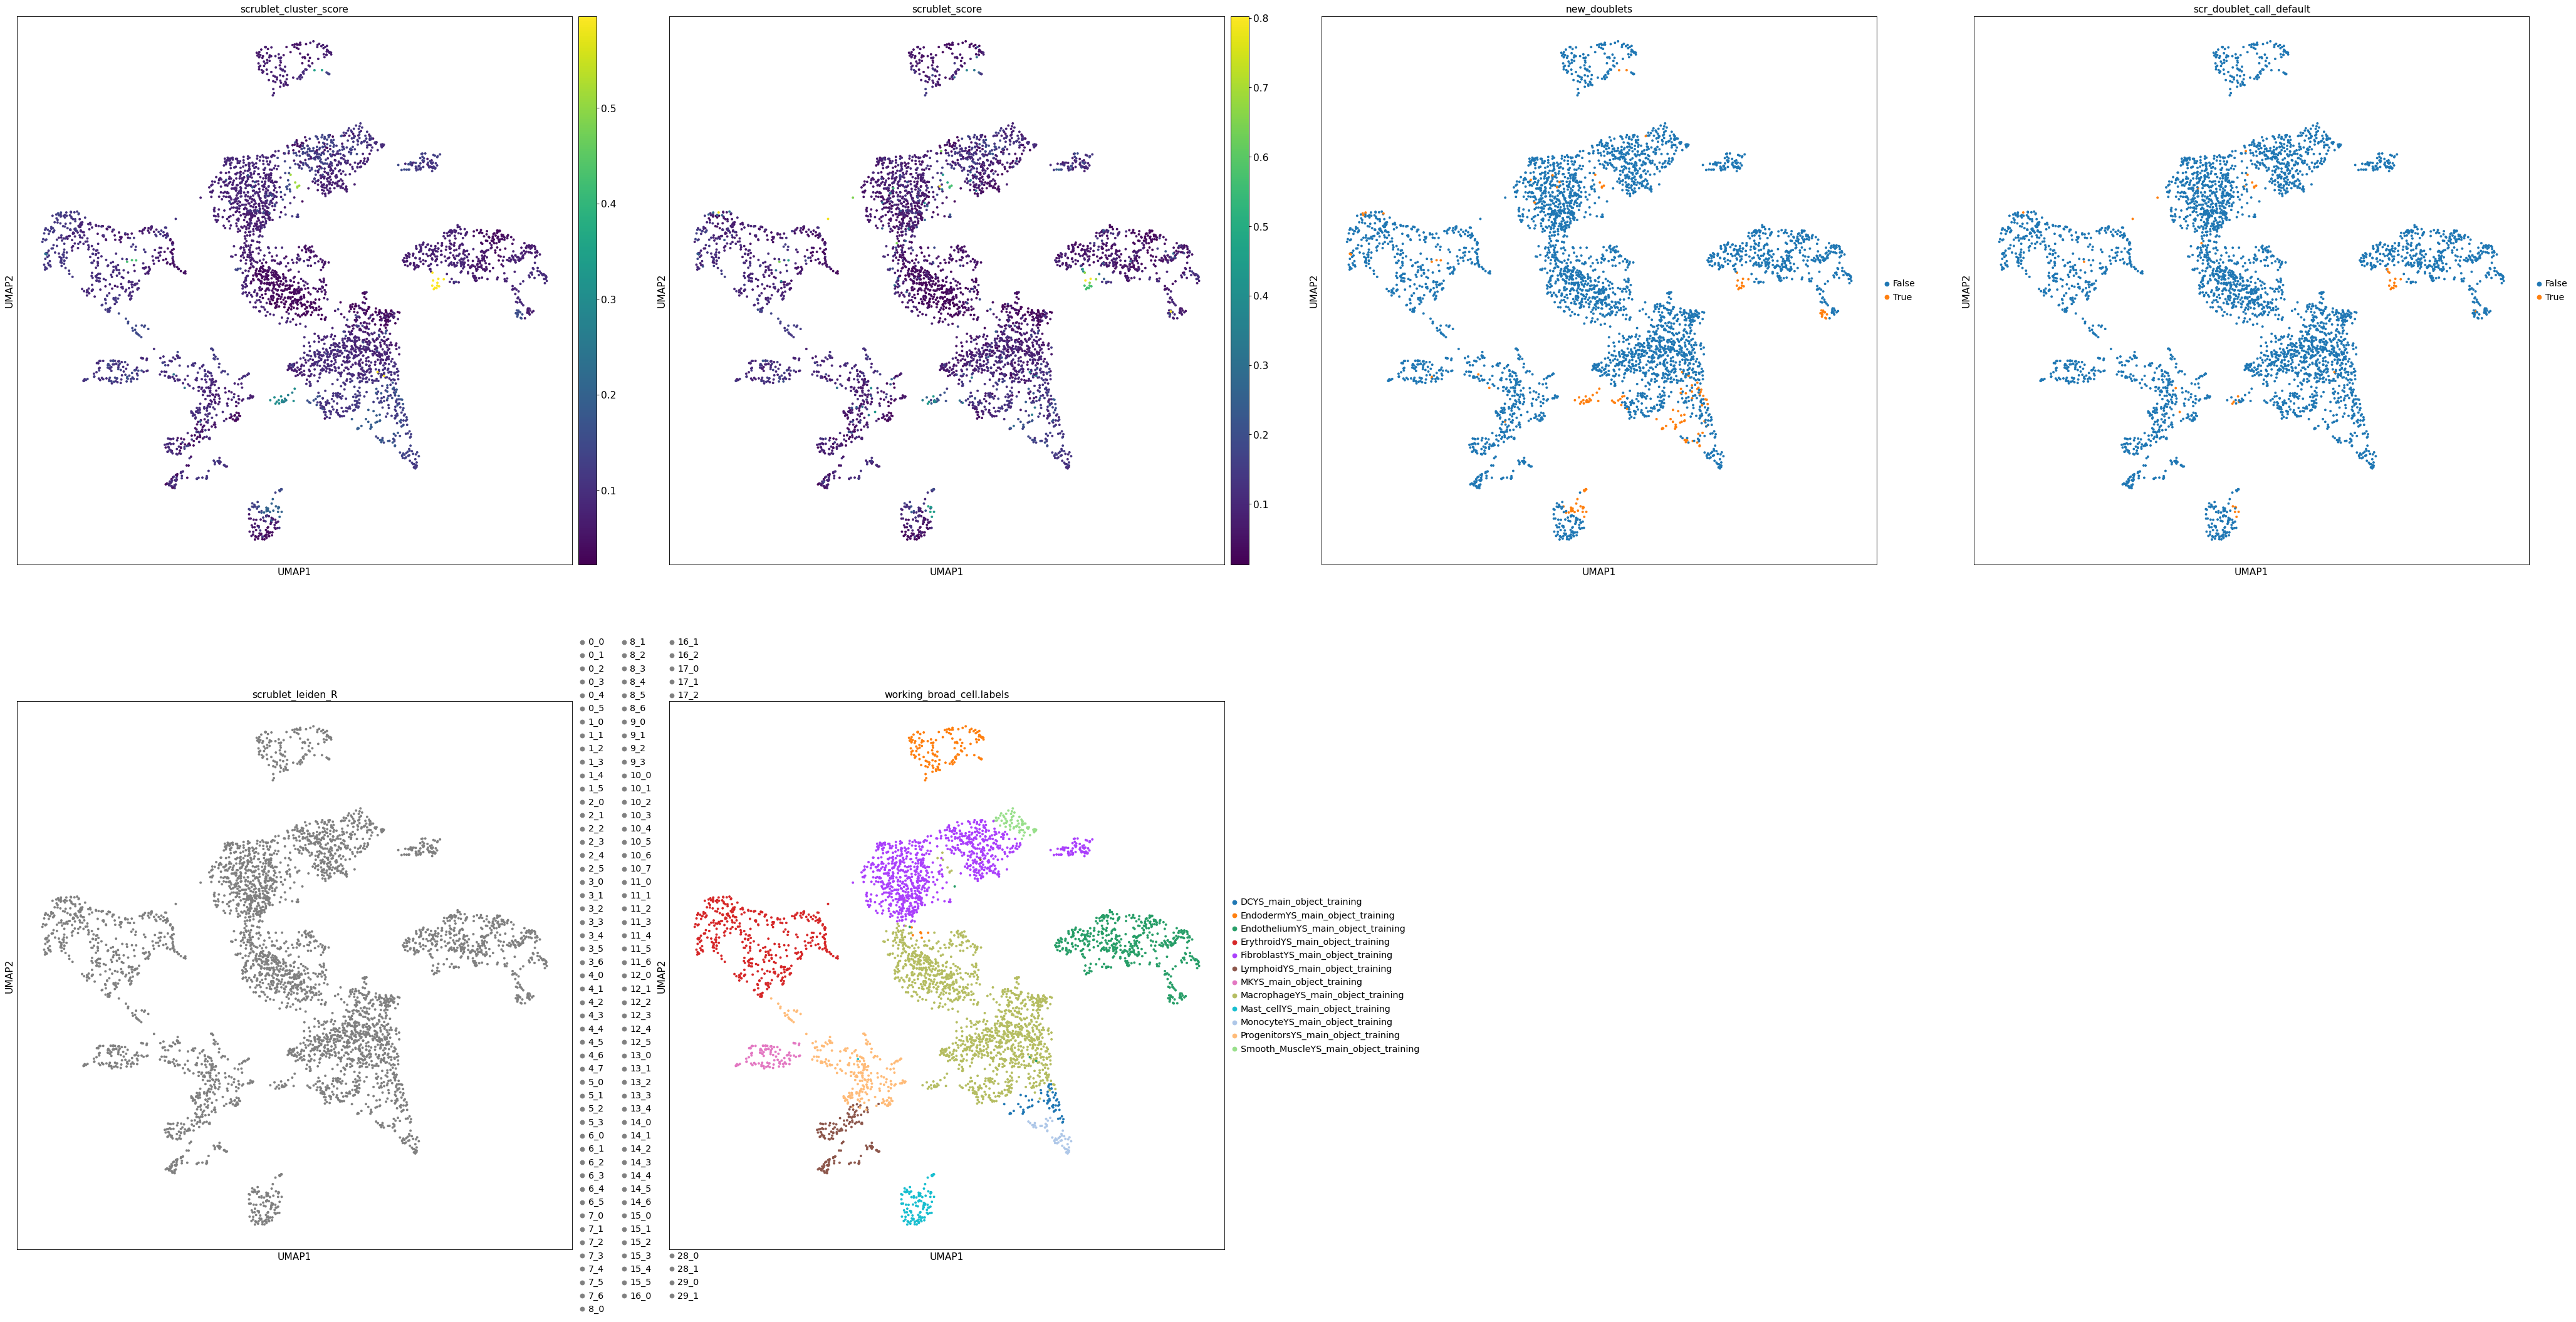

In [33]:
sc.pl.umap(adata,color=['scrublet_cluster_score','scrublet_score','new_doublets','scr_doublet_call_default','scrublet_leiden_R','working_broad_cell.labels'],size=50)

In [45]:
adata.obs.to_csv('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/new_doublets.csv')

# Subset out new doublets

In [29]:
adata.obs['new_doublets'].value_counts()

False    4168
True       53
Name: new_doublets, dtype: int64

In [30]:
adata.obs['new_doublets_bh'].value_counts()

False    4208
True       13
Name: new_doublets_bh, dtype: int64

In [31]:
adata = adata[adata.obs['new_doublets_bh']=='False']

In [32]:
adata

View of AnnData object with n_obs × n_vars = 4208 × 36601
    obs: 'identifier', 'sequencing.type', 'souporcell_doublet', 'souporcell_assignment', 'orig.ident', 'sex', 'sex_auto_assign', 'mad_prd', 'auto_prd', 'is_doublet', 'nUMI', 'nGene', 'nCounts', 'percent.mito', 'percent.ribo', 'n_counts', 'leiden_res1_1st_run', 'LR_indiv_pred', 'leiden_res1_1st_run_clus_redistribution', 'leiden_LR_clus_prediction_res5', 'working_broad_cell.labels', 'leiden_cluster10_restricted', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval', 'new_doublets', 'new_doublets_bh', 'scr_doublet_call_default'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '1st_run_neighbors', '1st_run_neighbors_harmony', 'hvg', 'is_doublet_colors', 'leiden', 'leiden_LR_clus_prediction_res5_colors', 'leiden_cluster10_restricted_colors', 'leiden_res1_1st_run_clus_redistribution_colors', 'leiden_res1_1st_run_colors', 'orig.ident_colors', 'p

In [54]:
adata.obs

,identifier,sequencing.type,souporcell_doublet,souporcell_assignment,orig.ident,sex,sex_auto_assign,mad_prd,auto_prd,is_doublet,...,working_broad_cell.labels,leiden_cluster10_restricted,scrublet_score,scrublet_cluster_score,scr_bh_pval,scr_pval,new_doublets,new_doublets_bh,scr_doublet_call_default,scrublet_leiden_R
AAACCCAGTATGGTTC-1-SIGAH5-SIGAH5,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,MacrophageYS_main_object_training,1,0.033248,0.040853,0.980645,0.979795,False,False,False,1_0
AAACCCAGTTCGGTTA-1-SIGAH5-SIGAH5,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,LymphoidYS_main_object_training,17,0.077799,0.088063,0.980645,0.747945,False,False,False,17_3
AAACGAAGTTCTTAGG-1-SIGAH5-SIGAH5,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,MacrophageYS_main_object_training,1,0.058824,0.069879,0.980645,0.884962,False,False,False,1_2
AAACGCTAGGACTGGT-1-SIGAH5-SIGAH5,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,ErythroidYS_main_object_training,15,0.033248,0.045845,0.980645,0.971510,False,False,False,15_1
AAACGCTCATCACAGT-1-SIGAH5-SIGAH5,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,MacrophageYS_main_object_training,1,0.098039,0.040853,0.980645,0.979795,False,False,False,1_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTGATTG-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,MacrophageYS_main_object_training,2,0.093023,0.080426,0.952702,0.536254,False,False,False,2_0
TTTGTTGCAGCTGTGC-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,MacrophageYS_main_object_training,5,0.122970,0.088186,0.952702,0.448687,False,False,False,5_1
TTTGTTGGTAATGTGA-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,EndotheliumYS_main_object_training,4,0.058296,0.076888,0.952702,0.575861,False,False,False,4_3
TTTGTTGGTCAGTCCG-1-SIGAG5-SIGAG5,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,FibroblastYS_main_object_training,3,0.038509,0.061191,0.952702,0.737705,False,False,False,3_4


In [63]:
save_object = adata[:]

In [64]:
save_object

View of AnnData object with n_obs × n_vars = 4221 × 36601
    obs: 'identifier', 'sequencing.type', 'souporcell_doublet', 'souporcell_assignment', 'orig.ident', 'sex', 'sex_auto_assign', 'mad_prd', 'auto_prd', 'is_doublet', 'nUMI', 'nGene', 'nCounts', 'percent.mito', 'percent.ribo', 'n_counts', 'leiden_res1_1st_run', 'LR_indiv_pred', 'leiden_res1_1st_run_clus_redistribution', 'leiden_LR_clus_prediction_res5', 'working_broad_cell.labels', 'leiden_cluster10_restricted', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval', 'new_doublets', 'new_doublets_bh', 'scr_doublet_call_default', 'scrublet_leiden_R'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '1st_run_neighbors', '1st_run_neighbors_harmony', 'hvg', 'is_doublet_colors', 'leiden', 'leiden_LR_clus_prediction_res5_colors', 'leiden_cluster10_restricted_colors', 'leiden_res1_1st_run_clus_redistribution_colors', 'leiden_res1_1st_run_colors', 'o

In [65]:
save_object.obs['new_doublets'].value_counts()

False    4061
True      160
Name: new_doublets, dtype: int64

In [66]:
save_object = save_object[save_object.obs['new_doublets']=='False']

In [67]:
save_object

View of AnnData object with n_obs × n_vars = 4061 × 36601
    obs: 'identifier', 'sequencing.type', 'souporcell_doublet', 'souporcell_assignment', 'orig.ident', 'sex', 'sex_auto_assign', 'mad_prd', 'auto_prd', 'is_doublet', 'nUMI', 'nGene', 'nCounts', 'percent.mito', 'percent.ribo', 'n_counts', 'leiden_res1_1st_run', 'LR_indiv_pred', 'leiden_res1_1st_run_clus_redistribution', 'leiden_LR_clus_prediction_res5', 'working_broad_cell.labels', 'leiden_cluster10_restricted', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval', 'new_doublets', 'new_doublets_bh', 'scr_doublet_call_default', 'scrublet_leiden_R'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '1st_run_neighbors', '1st_run_neighbors_harmony', 'hvg', 'is_doublet_colors', 'leiden', 'leiden_LR_clus_prediction_res5_colors', 'leiden_cluster10_restricted_colors', 'leiden_res1_1st_run_clus_redistribution_colors', 'leiden_res1_1st_run_colors', 'o

In [77]:
save_object.write_h5ad('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/cite_seq_object_new_doublets_removed_20211001.h5ad')

Data 1 counts min: 0.0
Data 1 counts max: 64.96922302246094
Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value


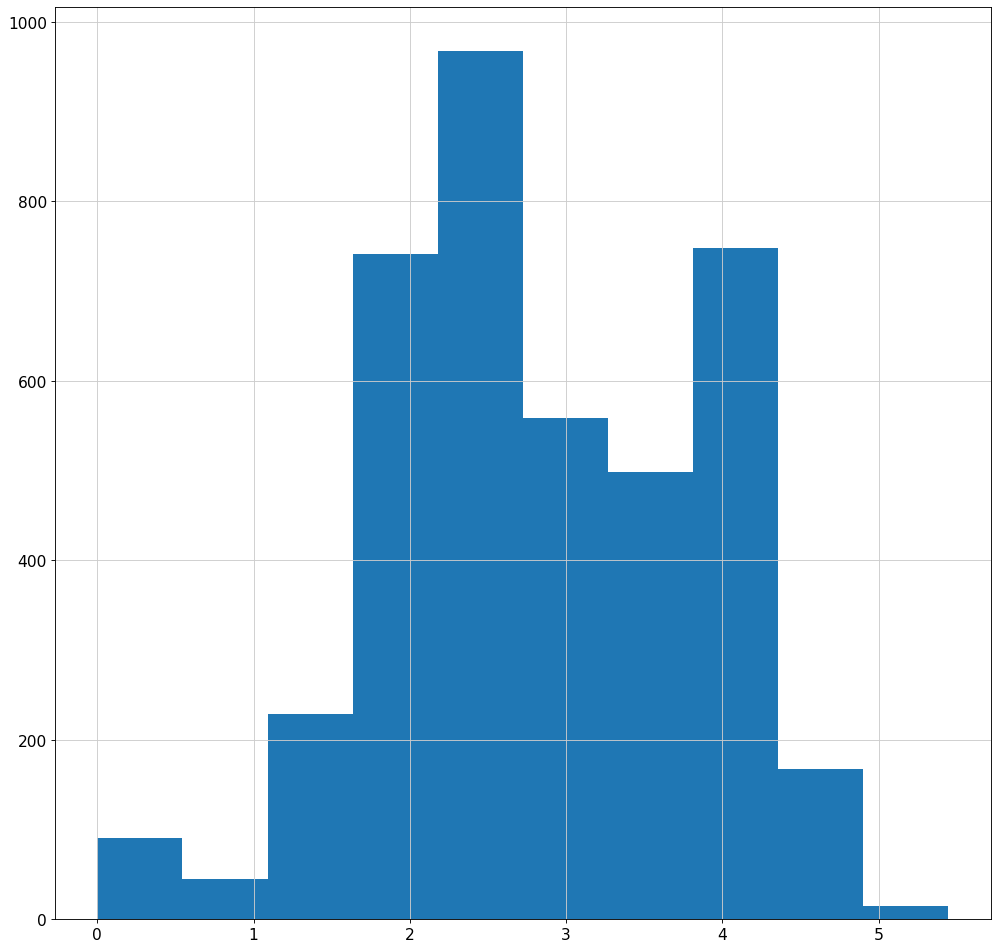

In [73]:
# Note data object save is processed

# to show counts data is not raw
array1 = save_object.X.toarray()
data = save_object.X.todense()
data1 = pd.DataFrame(data)
data1.columns = save_object.var.index
data1.index = save_object.obs.index
print(f'Data 1 counts min: {array1.min()}')
print(f'Data 1 counts max: {array1.max()}')
print('Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value')
plt.hist(data1.loc[:,'FTL'])
plt.show() 
print("")

# Check embedding using rand and mi

In [69]:
# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(save_object.obs['LR_indiv_pred']), list(save_object.obs['working_broad_cell.labels']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(save_object.obs['LR_indiv_pred']), list(save_object.obs['working_broad_cell.labels']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)): # high cutoff parameters
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))

success
You have achieved good consensus between predicted labels and consensus leiden labels
Adj Rand extimate = 0.853231476348436  Mutual Information score=0.8125901851832343


### Rand and mi scores are good therefore don't need to recreate embedding 

In [30]:
# Adapt scanpy setting to better view umaps within the script
sc.settings.set_figure_params(dpi=300)

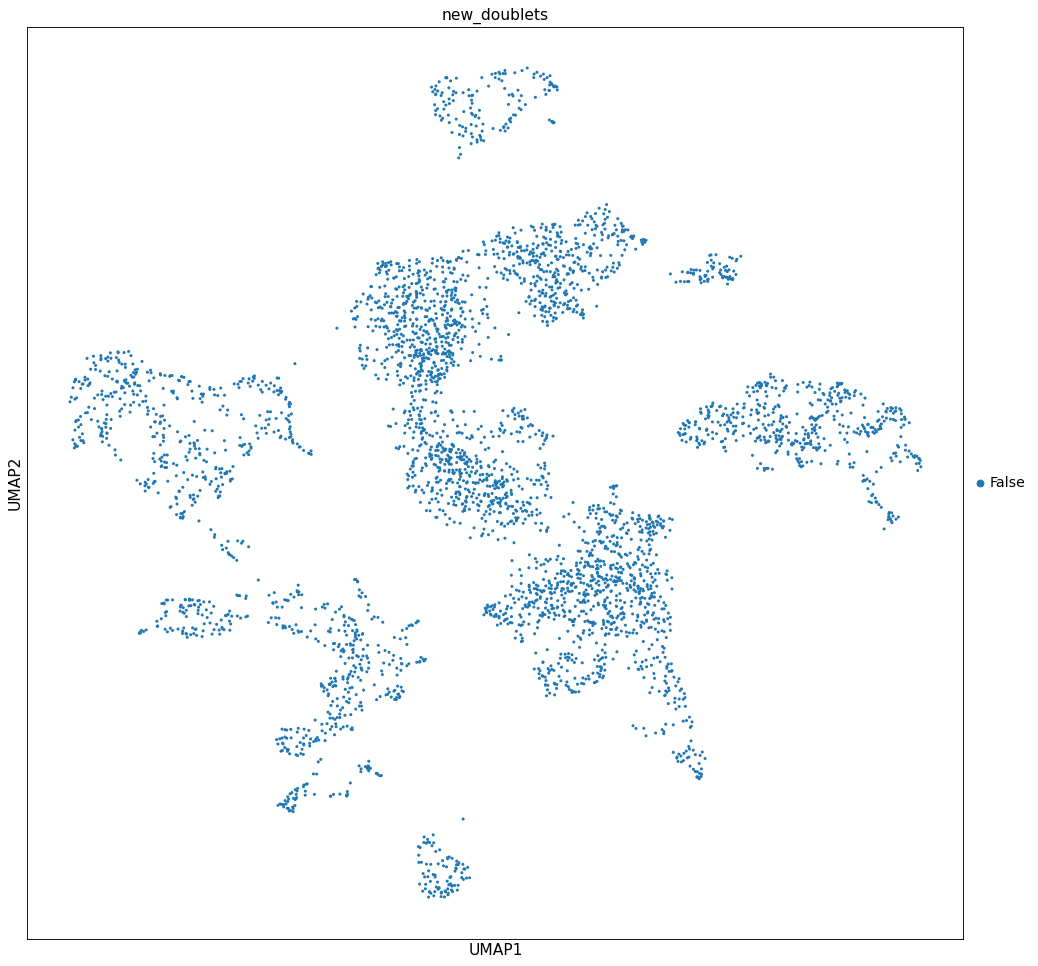

In [70]:
sc.pl.umap(save_object, color='new_doublets')

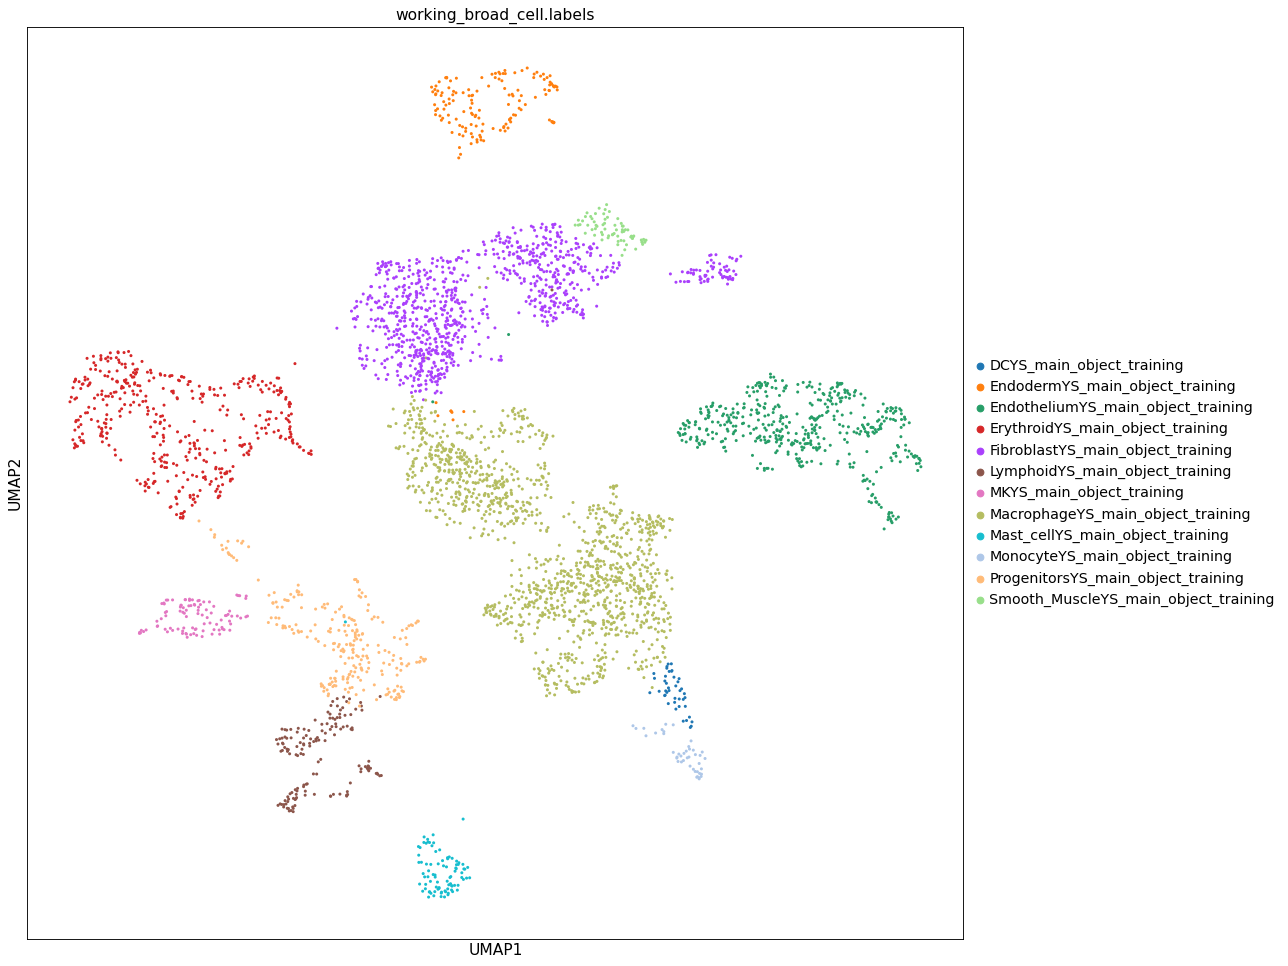

In [71]:
sc.pl.umap(save_object, color='working_broad_cell.labels')

In [74]:
adata_raw = save_object[:]

In [75]:
adata_raw = adata_raw.raw.to_adata()

Data 1 counts min: 0.0
Data 1 counts max: 31959.0
Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value


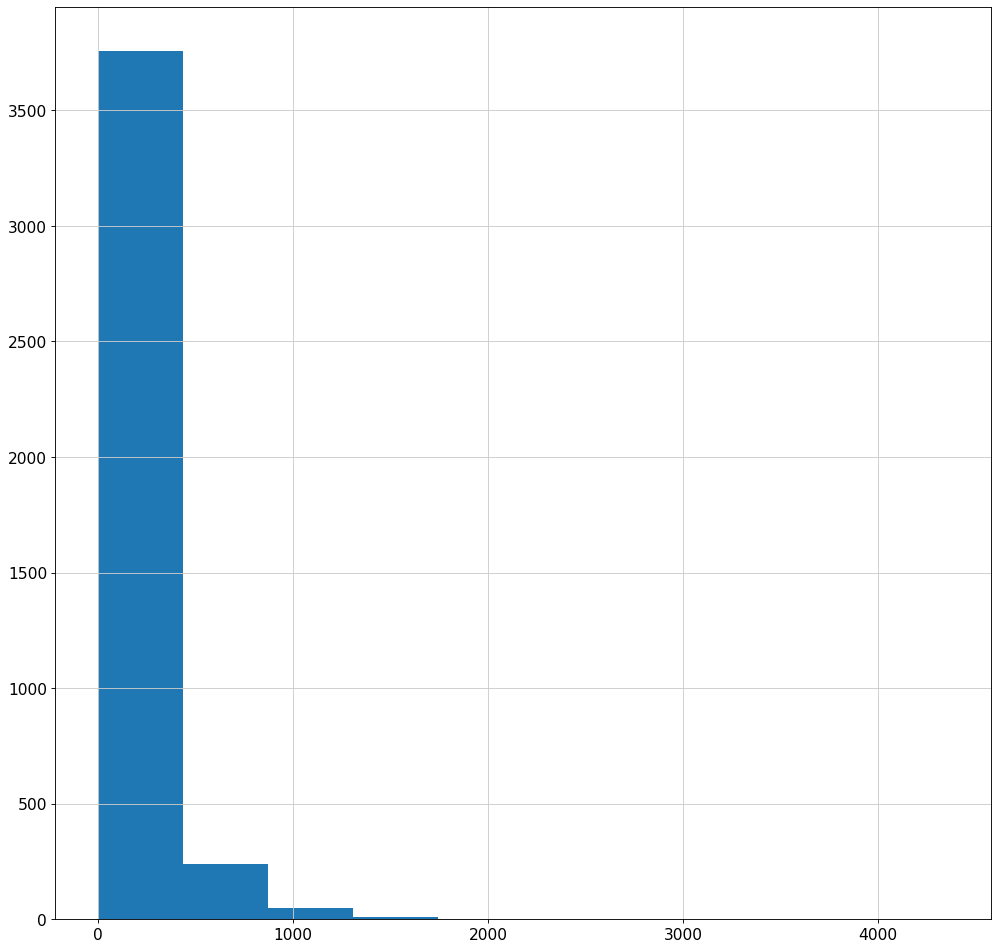

In [76]:
# to show counts data is not raw
array1 = adata_raw.X.toarray()
data = adata_raw.X.todense()
data1 = pd.DataFrame(data)
data1.columns = adata_raw.var.index
data1.index = adata_raw.obs.index
print(f'Data 1 counts min: {array1.min()}')
print(f'Data 1 counts max: {array1.max()}')
print('Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value')
plt.hist(data1.loc[:,'FTL'])
plt.show() 
print("")

In [78]:
adata_raw.write_h5ad('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/cite_seq_object_new_doublets_removed_raw_20211001.h5ad')

# Tidy up data object - probably could be added to the end of the LR script of comparison (script 11)

# Save the object 

In [22]:
p = Path(save_path)
adata.write(Path(p,Object_unique_name + '_' + date  +'.h5ad'))

# Save a raw copy of the object

Data 1 counts min: 0.0
Data 1 counts max: 64.96922302246094
Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value


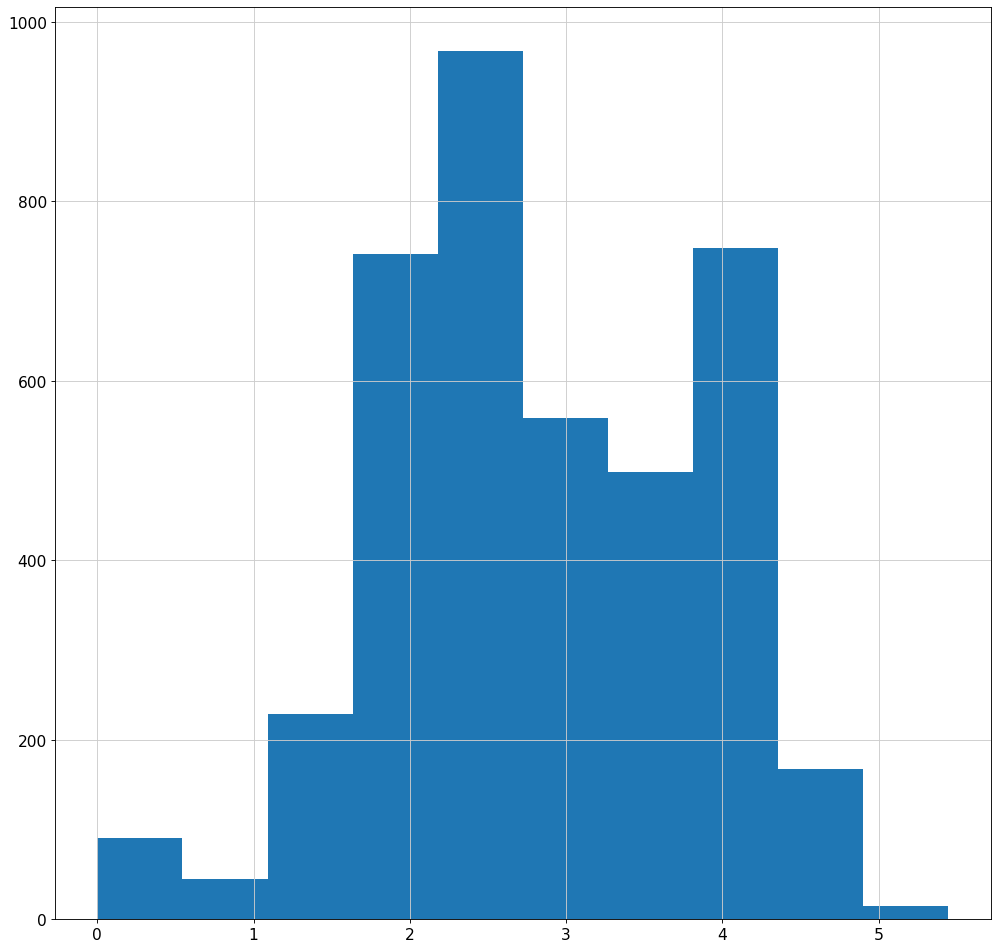

In [73]:
# to show counts data is not raw
array1 = save_object.X.toarray()
data = save_object.X.todense()
data1 = pd.DataFrame(data)
data1.columns = save_object.var.index
data1.index = save_object.obs.index
print(f'Data 1 counts min: {array1.min()}')
print(f'Data 1 counts max: {array1.max()}')
print('Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value')
plt.hist(data1.loc[:,'FTL'])
plt.show() 
print("")

In [23]:
adata_raw = adata[:]

In [24]:
adata_raw = adata_raw.raw.to_adata()

Data 1 counts min: 0.0
Data 1 counts max: 31959.0
Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value


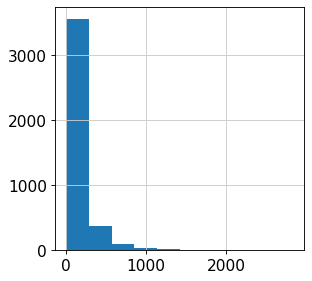

In [25]:
# to show counts data is not raw
array1 = adata_raw.X.toarray()
data = adata_raw.X.todense()
data1 = pd.DataFrame(data)
data1.columns = adata_raw.var.index
data1.index = adata_raw.obs.index
print(f'Data 1 counts min: {array1.min()}')
print(f'Data 1 counts max: {array1.max()}')
print('Plotting histogram of Data1 for Gene "FTL" to visualise general distribution of counts. Y axis: Cell number, X axis: Counts value')
plt.hist(data1.loc[:,'FTL'])
plt.show() 
print("")

In [27]:
p = Path(save_path)
adata_raw.write(Path(p,Object_unique_name + 'raw_for_LR_comparison_' + date  +'.h5ad'))